In this notebook, we perform harmonization of the lymph node data with the totalVI data, perform quality control, check for doublets, as well as annotation. Refer to the other notebook for analysis

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
import scipy.io
import seaborn as sb
import anndata

import matplotlib.pyplot as plt
%matplotlib inline

save_path = "/home/ubuntu/mouse_lymph_node/nova/"

### Load data

In [2]:
adata = sc.read_h5ad("harmonized_total_VI_and_nova_run.h5ad")

### Filter the data and only focus on the nova-seq run, with a new umap

In [3]:
# use our data only
adata = adata[[int(x) < 4 for x in adata.obs["batch"].values]].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [4]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(adata, min_dist=0.1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [7]:
adata.obs.columns

Index(['n_genes', 'cell_types', 'batch', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt', 'pct_counts_mt', 'doublets_scores',
       'doublets_predictions', 'SCANVI_pred_cell_types', 'MS',
       'SCVI_pred_cell_types'],
      dtype='object')

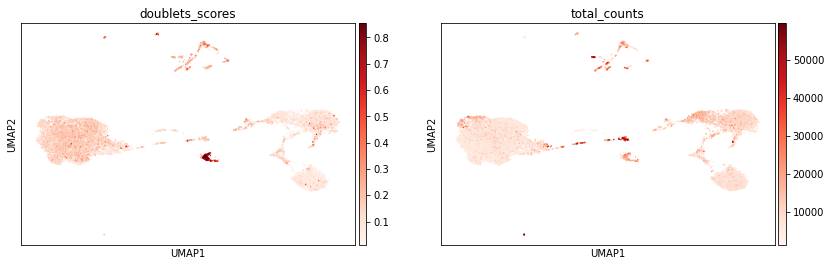

In [10]:
sc.pl.umap(adata, color=["doublets_scores", "total_counts"], cmap="Reds")

### check the annotation from the pipeline

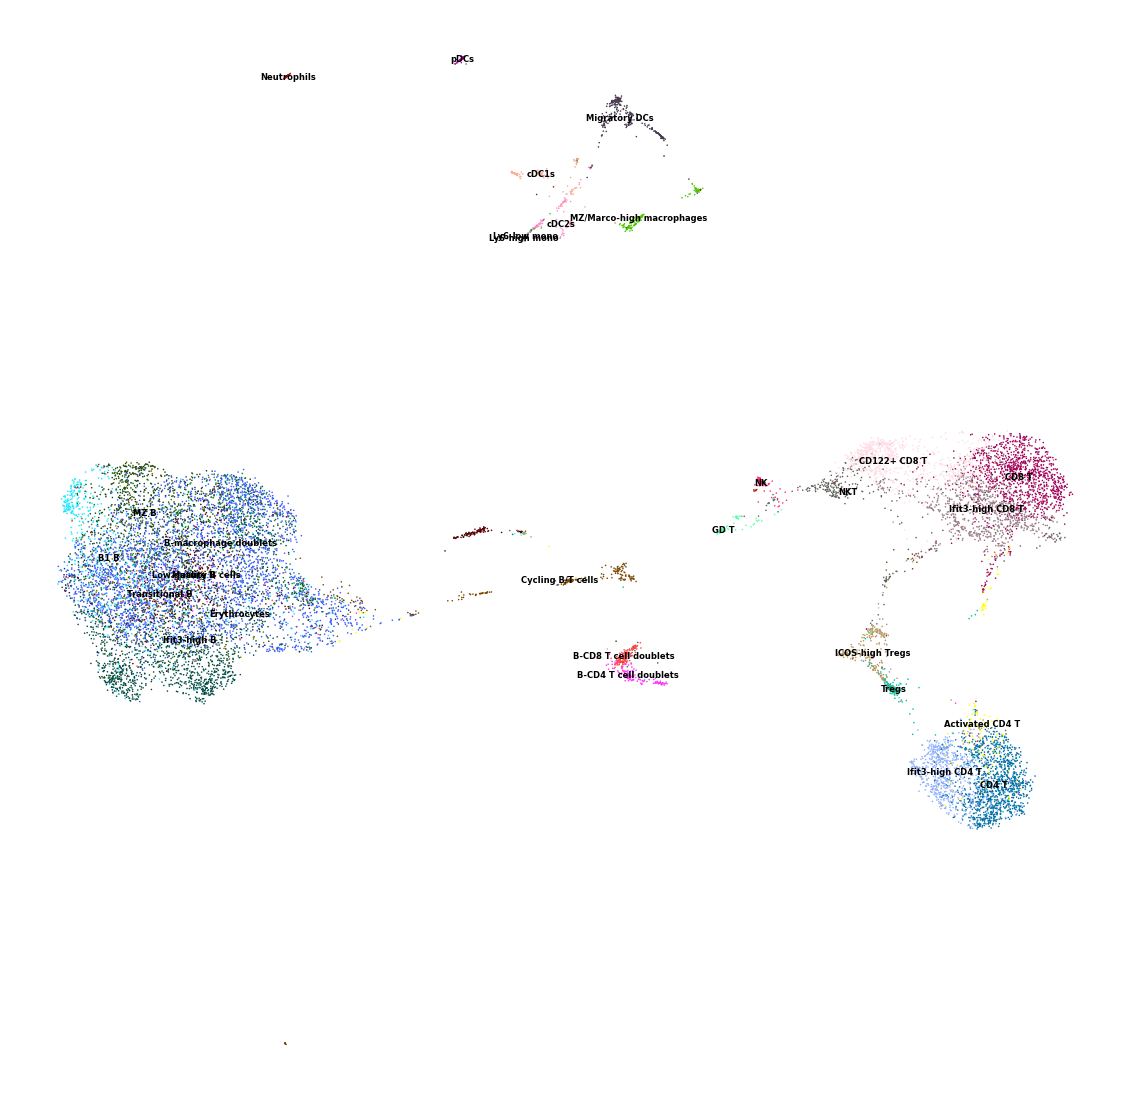

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata, 
    color="SCANVI_pred_cell_types",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, size=10
)

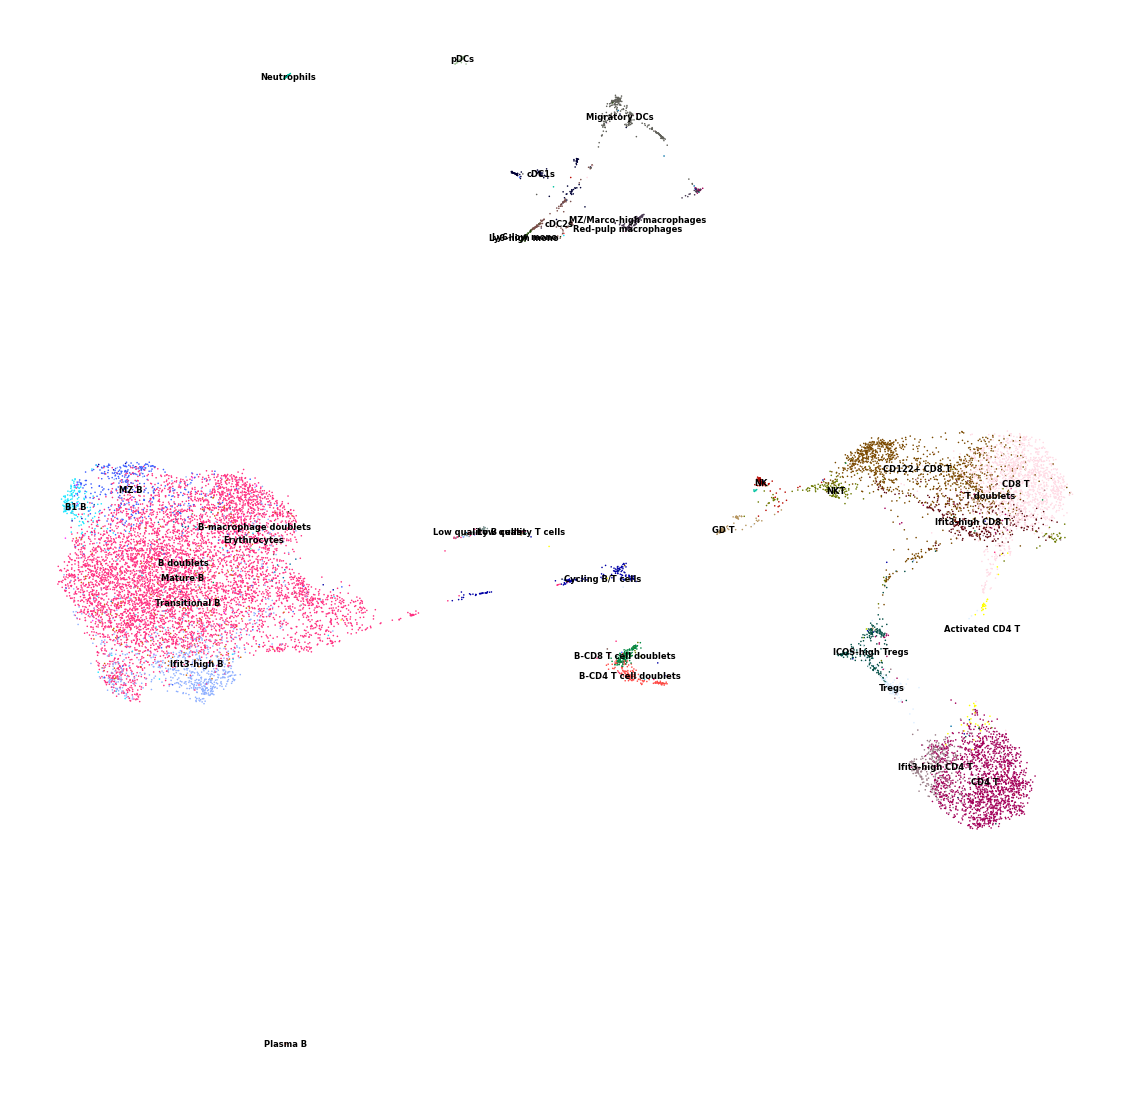

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata, 
    color="SCVI_pred_cell_types",
    frameon=False,
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, size=10
)

## curate the annotations with clustering

In [15]:
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

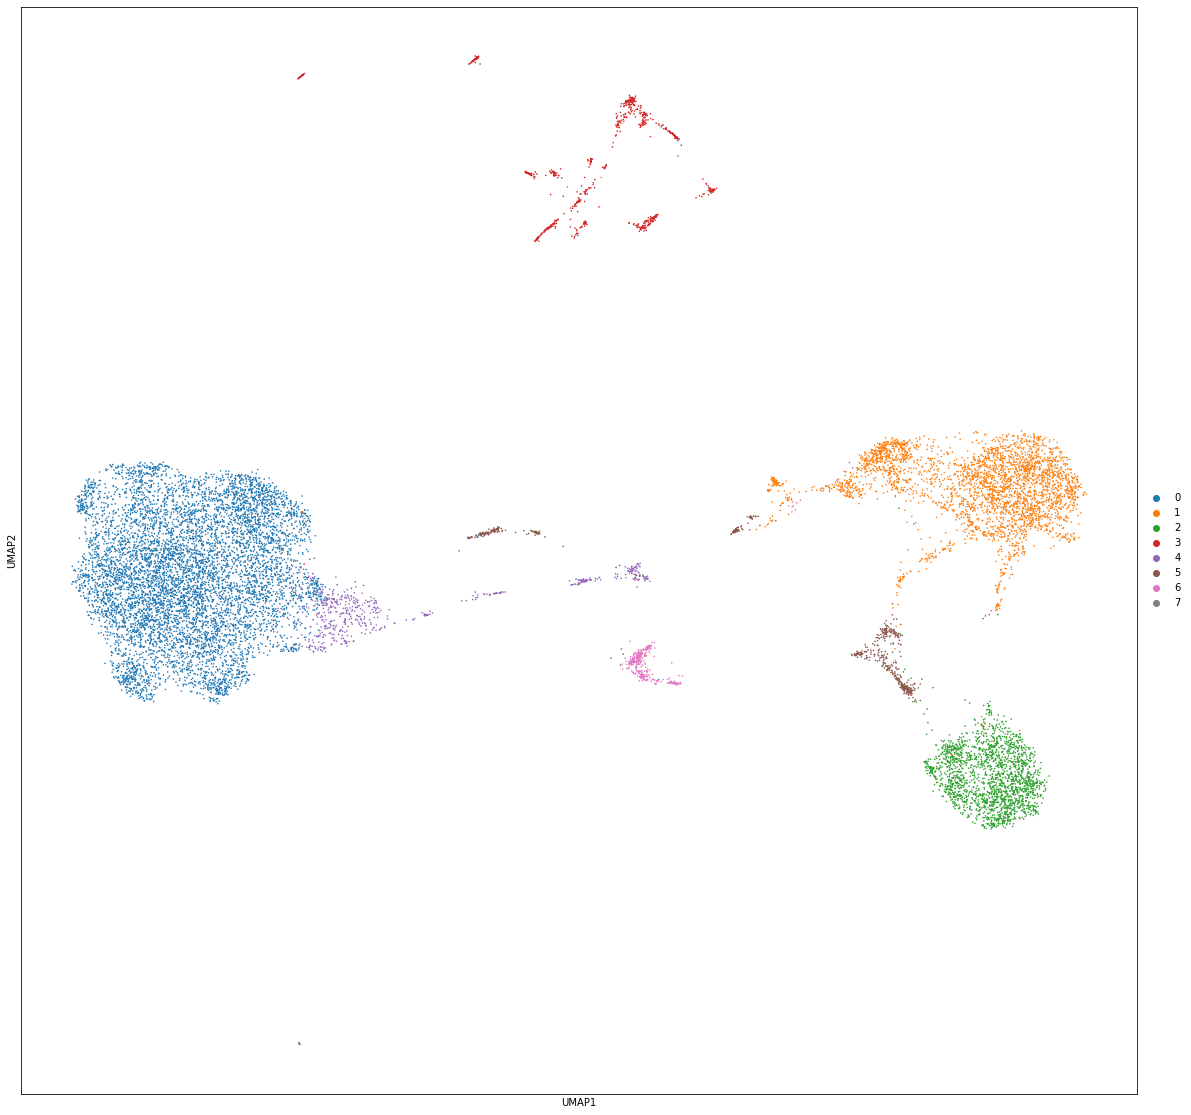

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata, 
    color="louvain_r0.5",
    title="",
    ax=ax, size=10
)

In [59]:
def study_labels_heterogeneity(key_1, key_2):
    plt.figure(figsize=(10, 10))
    profile = pd.DataFrame(data=adata.obs[[key_1, key_2]])
    x_list = np.unique(adata.obs[key_1])
    y_list = np.unique(adata.obs[key_2])
    x_n = len(x_list)
    y_n = len(y_list)

    proportion = np.zeros(shape=(x_n, y_n))
    for i, x in enumerate(x_list):
        for j, y in enumerate(y_list):
            proportion[i, j] = np.sum(profile[profile[key_1] == x][key_2] == y)
    proportion /= np.sum(proportion, axis=1)[:, np.newaxis] 

    plt.imshow(proportion.T)
    plt.colorbar()
    plt.xticks(range(x_n), x_list, rotation=35)
    plt.yticks(range(y_n), y_list, rotation=35)
    plt.xlabel(key_1)
    plt.ylabel(key_2)
    plt.show()
    
    for i, x in enumerate(x_list):
        line_string = F'Cluster {x}: '
        pile = []
        # empile
        for j, y in enumerate(y_list):
            if proportion[i, j] > 0.05:
                pile.append([y, proportion[i, j]])
        # depile
        for y, p in sorted(pile, key=lambda x:x[1])[::-1]:
            line_string += F'{y} present at ratio {p:.2f}, '
        print(line_string)

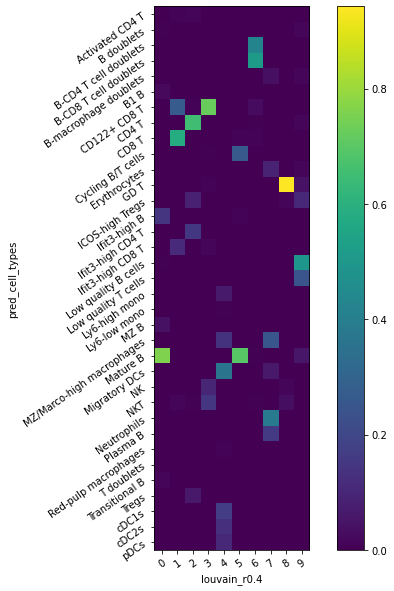

Cluster 0: Mature B present at ratio 0.76, Ifit3-high B present at ratio 0.15, 
Cluster 1: CD8 T present at ratio 0.58, CD122+ CD8 T present at ratio 0.27, Ifit3-high CD8 T present at ratio 0.12, 
Cluster 2: CD4 T present at ratio 0.65, Ifit3-high CD4 T present at ratio 0.15, ICOS-high Tregs present at ratio 0.09, Tregs present at ratio 0.06, 
Cluster 3: CD122+ CD8 T present at ratio 0.72, NKT present at ratio 0.15, NK present at ratio 0.10, 
Cluster 4: Migratory DCs present at ratio 0.36, cDC1s present at ratio 0.17, MZ/Marco-high macrophages present at ratio 0.14, cDC2s present at ratio 0.13, pDCs present at ratio 0.10, Ly6-high mono present at ratio 0.07, 
Cluster 5: Mature B present at ratio 0.70, Cycling B/T cells present at ratio 0.26, 
Cluster 6: B-CD8 T cell doublets present at ratio 0.51, B-CD4 T cell doublets present at ratio 0.42, 
Cluster 7: Neutrophils present at ratio 0.39, MZ/Marco-high macrophages present at ratio 0.25, Plasma B present at ratio 0.16, Erythrocytes prese

In [60]:
study_labels_heterogeneity("louvain_r0.5", "SCANVI_pred_cell_types")

Cluster 0: B cells

Cluster 1: CD8 T cells

Cluster 2: CD4 T cells

**Cluster 3**: CD122+ CD8 T present at ratio 0.72, NKT present at ratio 0.15, NK present at ratio 0.10, 

**Cluster 4**: Migratory DCs present at ratio 0.36, cDC1s present at ratio 0.17, MZ/Marco-high macrophages present at ratio 0.14, cDC2s present at ratio 0.13, pDCs present at ratio 0.10, Ly6-high mono present at ratio 0.07, 

Cluster 5: Mature Cycling B cells 

**Cluster 6**: ICOS-high Tregs present at ratio 0.36, Tregs present at ratio 0.22, GD T present at ratio 0.16, Low quality B cells present at ratio 0.08, CD122+ CD8 T present at ratio 0.06, 

**Cluster 7**: Ifit3-high B present at ratio 0.71, B1 B present at ratio 0.12, MZ B present at ratio 0.10, Plasma B present at ratio 0.05, 

Cluster 8: Doublets, **filter for the rest of the analysis**

**Cluster 9**: Neutrophils present at ratio 0.46, MZ/Marco-high macrophages present at ratio 0.32, Erythrocytes present at ratio 0.11, Migratory DCs present at ratio 0.08,

Bold means need to **recluster**!

In [105]:
# recluster 1 et 3 to separate CD8 from NK cells
sc.tl.louvain(adata, restrict_to = ("louvain_r0.5", ["1", "3"]), key_added="louvain_sub", resolution=0.4, random_state=0)

In [116]:
# recluster 7 to isolate plasma cells
sc.tl.louvain(adata, restrict_to = ("louvain_sub", ["7"]), key_added="louvain_sub_1", resolution=0.4, random_state=0)

In [120]:
# recluster 6 to isolate Tregs from GD cells and low quality cells
sc.tl.louvain(adata, restrict_to = ("louvain_sub_1", ["6"]), key_added="louvain_sub_2", resolution=0.2, random_state=0)

In [156]:
# recluster 4 and 9 to get the innate immune cells in greater detail
sc.tl.louvain(adata, restrict_to = ("louvain_sub_2", ["4", "9"]), key_added="louvain_sub_3", resolution=0.5, random_state=0)

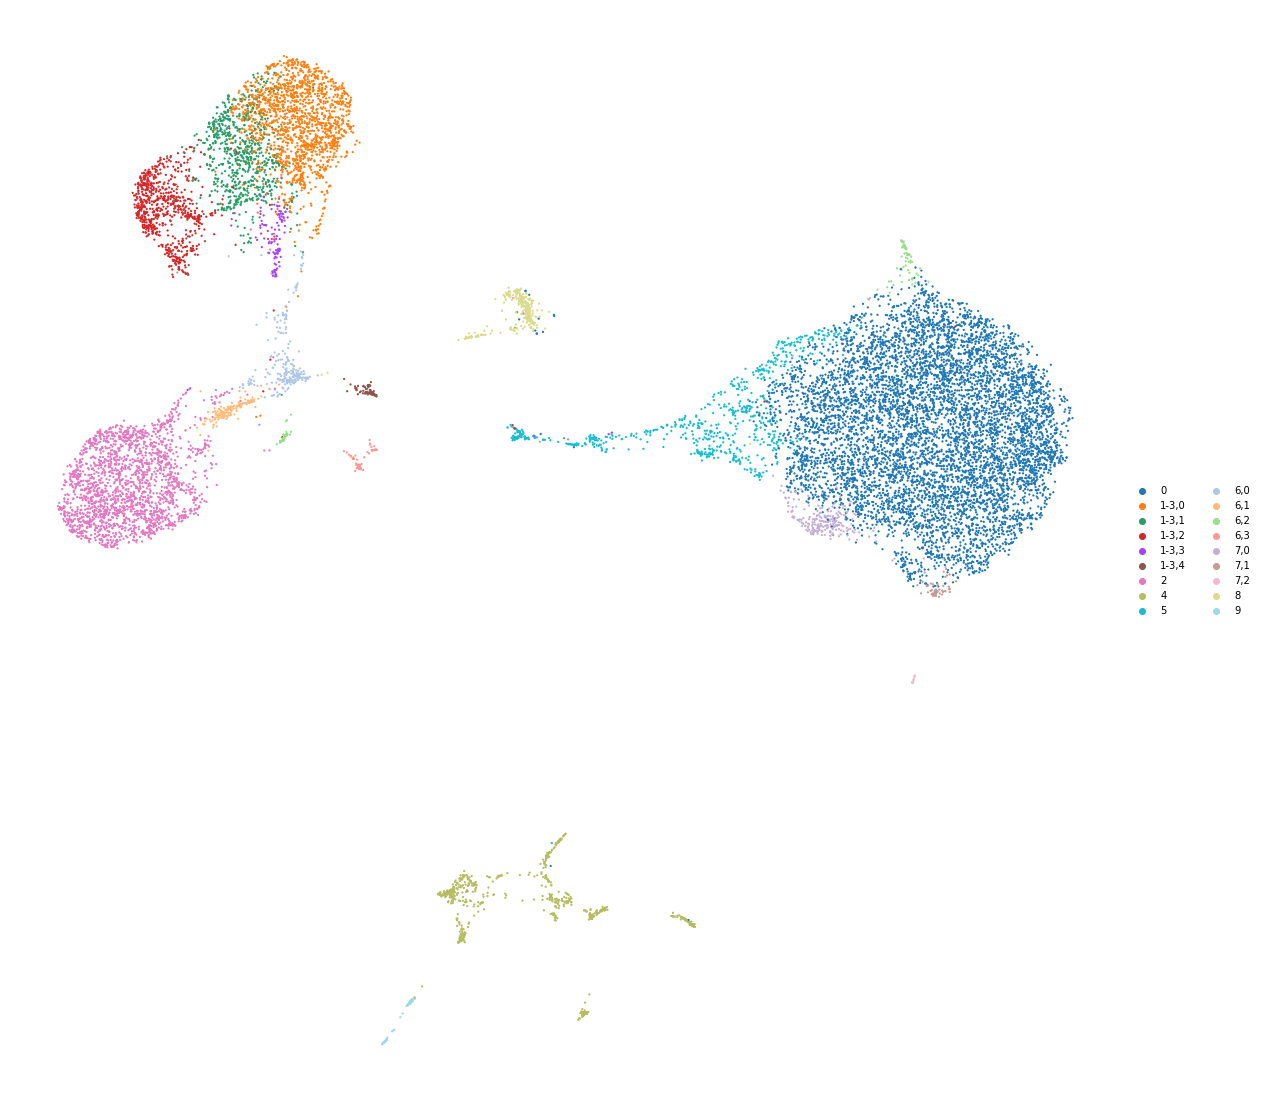

In [162]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata, 
    color="louvain_sub_2",
    frameon=False,
    title="",
    ax=ax, size=20
)

Trying to set attribute `.uns` of view, copying.


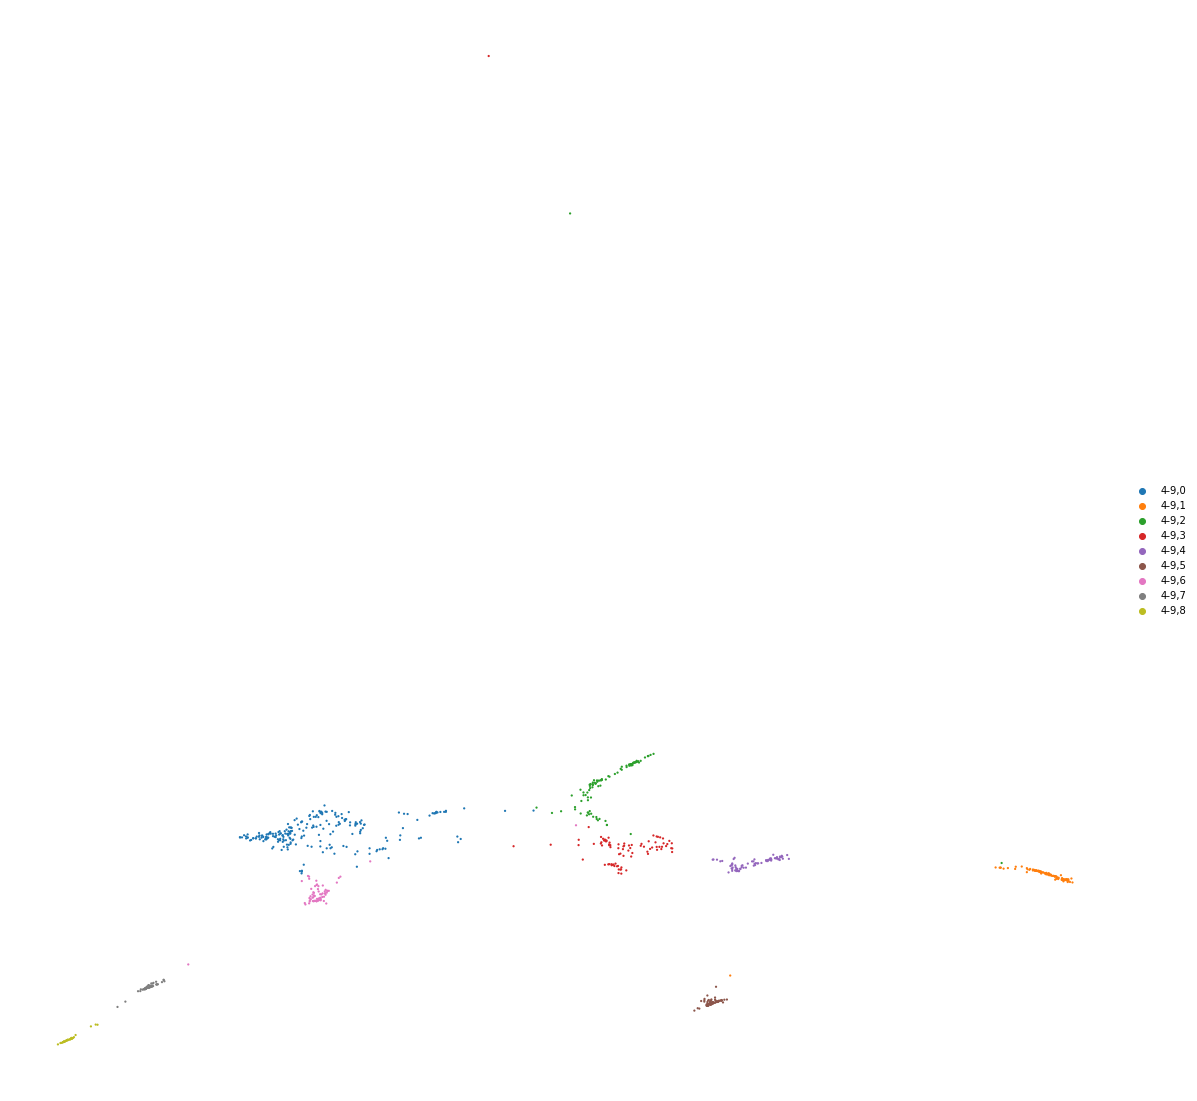

In [157]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata[[c in ["4", "9"] for c in adata.obs["louvain_r0.5"]]], 
    color="louvain_sub_3",
    frameon=False,
    title="",
    ax=ax, size=20
)

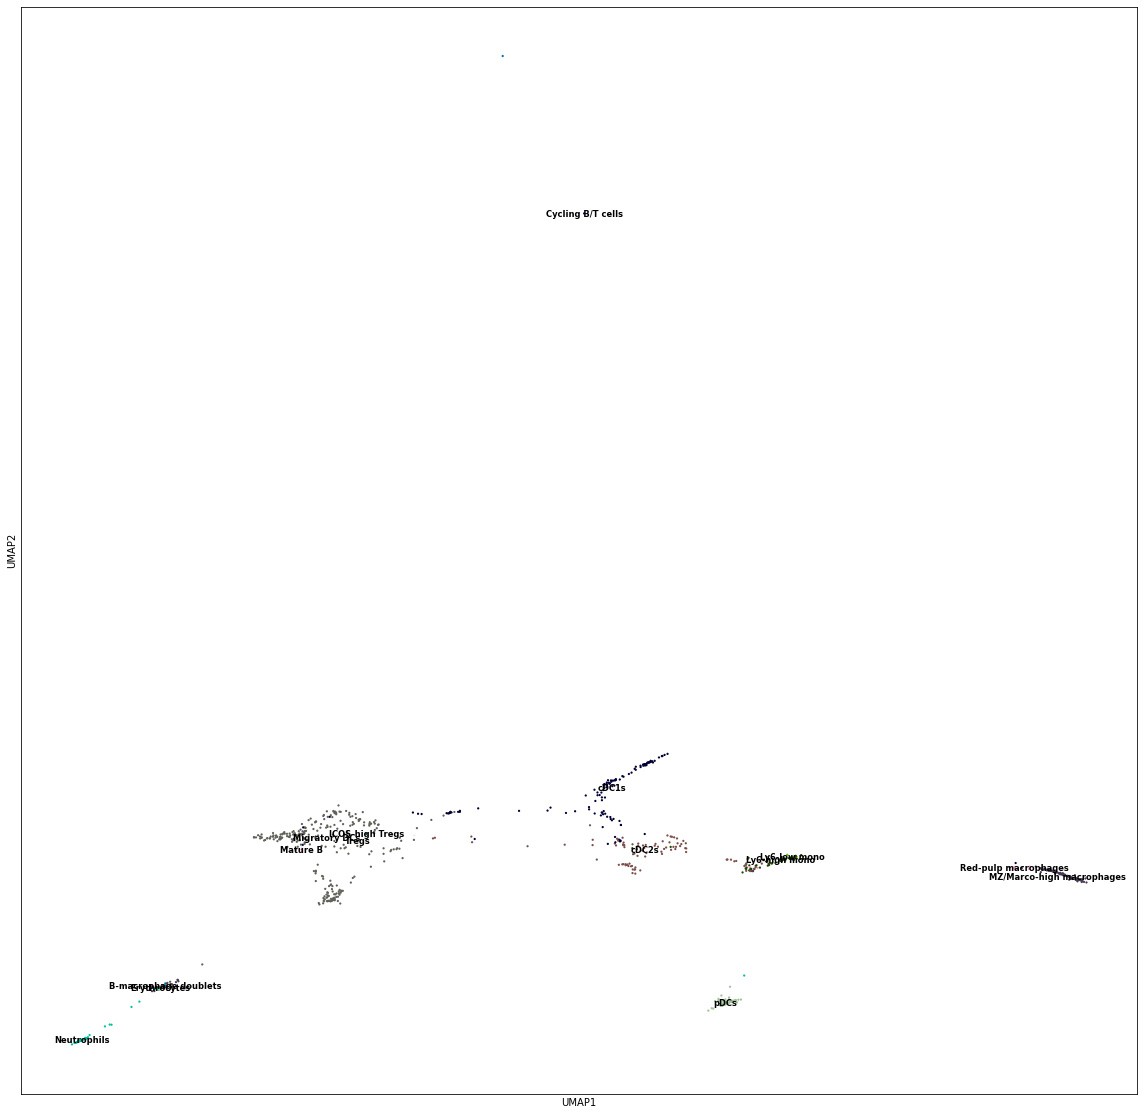

In [140]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata[[c in ["4", "9"] for c in adata.obs["louvain_r0.5"]]], 
    color="pred_cell_types",
    title="",
    legend_loc="on data",
    legend_fontsize="small",
    ax=ax, size=20
)

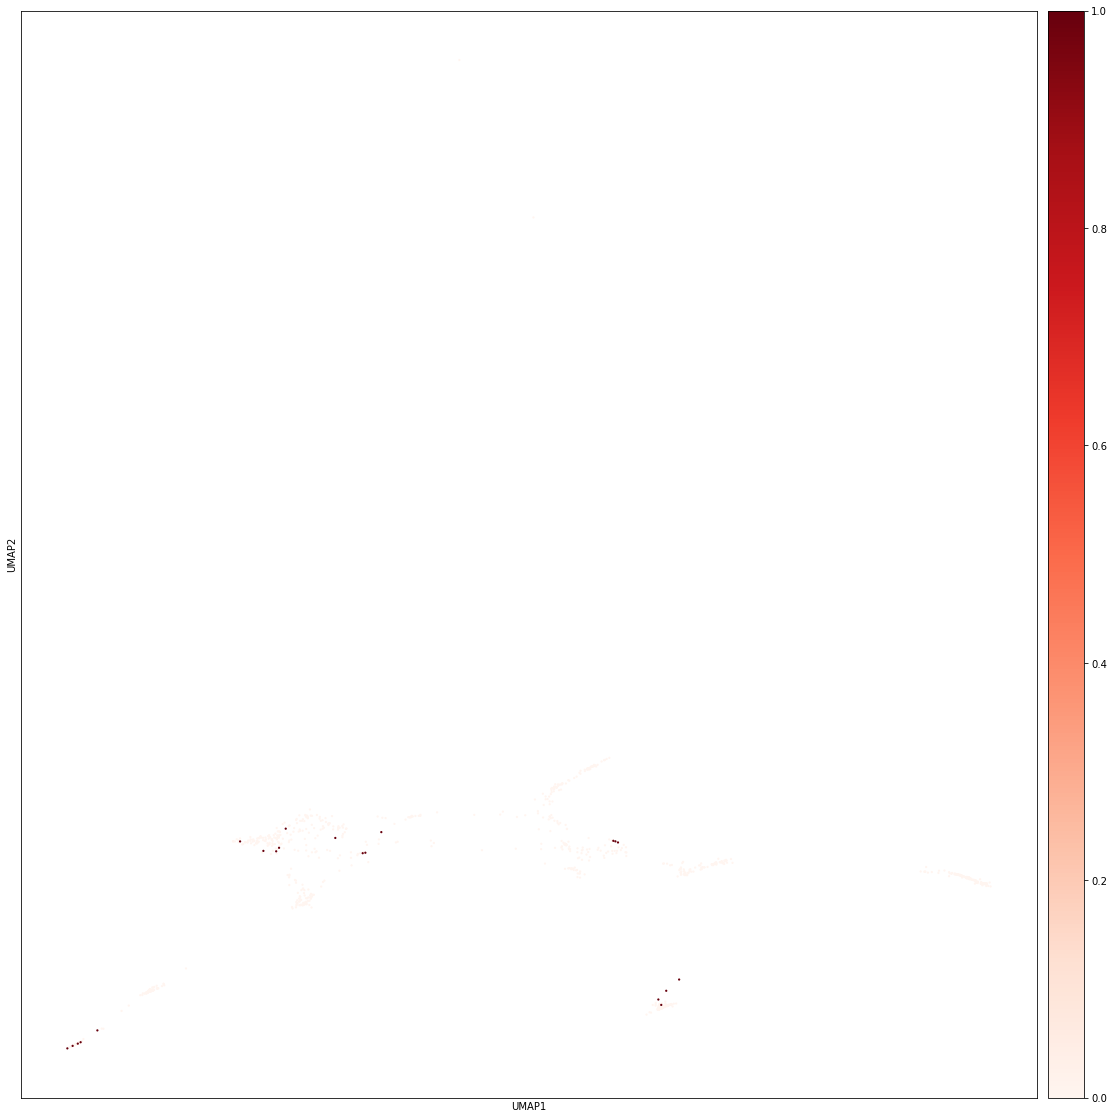

In [177]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.umap(
    adata[[c in ["4", "9"] for c in adata.obs["louvain_r0.5"]]], 
    color="doublet_predictions",
    title="", cmap="Reds",
    ax=ax, size=20
)

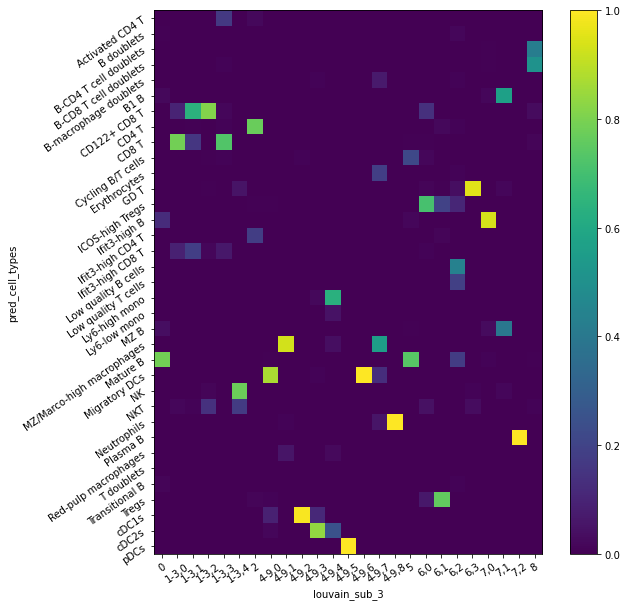

Cluster 0: Mature B present at ratio 0.79, Ifit3-high B present at ratio 0.13, 
Cluster 1-3,0: CD8 T present at ratio 0.79, CD122+ CD8 T present at ratio 0.10, Ifit3-high CD8 T present at ratio 0.09, 
Cluster 1-3,1: CD122+ CD8 T present at ratio 0.64, Ifit3-high CD8 T present at ratio 0.18, CD8 T present at ratio 0.16, 
Cluster 1-3,2: CD122+ CD8 T present at ratio 0.81, NKT present at ratio 0.14, 
Cluster 1-3,3: CD8 T present at ratio 0.73, Activated CD4 T present at ratio 0.17, Ifit3-high CD8 T present at ratio 0.07, 
Cluster 1-3,4: NK present at ratio 0.77, NKT present at ratio 0.17, GD T present at ratio 0.05, 
Cluster 2: CD4 T present at ratio 0.77, Ifit3-high CD4 T present at ratio 0.18, 
Cluster 4-9,0: Migratory DCs present at ratio 0.87, cDC1s present at ratio 0.09, 
Cluster 4-9,1: MZ/Marco-high macrophages present at ratio 0.93, Red-pulp macrophages present at ratio 0.06, 
Cluster 4-9,2: cDC1s present at ratio 0.99, 
Cluster 4-9,3: cDC2s present at ratio 0.84, cDC1s present at 

In [171]:
study_labels_heterogeneity("louvain_sub_3", "SCANVI_pred_cell_types")

Remarks:
+ Cluster 0: B
+ Cluster 1-3,0: CD8 T 
+ Cluster 1-3,1: CD8 T
+ Cluster 1-3,2: CD8 T & NKT -> CD8 T 
+ Cluster 1-3,3: CD8 T (& Activated CD4 T ,error) -> CD8T 
+ Cluster 1-3,4: NK & NKT -> NK
+ Cluster 2: CD4 T 
+ Cluster 4-9,0: Migratory DCs (& cDC1s, error for sure)
+ Cluster 4-9,1: Macrophages
+ Cluster 4-9,2: cDC1s
+ Cluster 4-9,3: cDC2s (& cDC1s, should be error?),
+ Cluster 4-9,4: Monocytes (& cDC2s error for sure, those are the inflammed monocytes),
+ Cluster 4-9,5: pDCs 
+ Cluster 4-9,6: Migratory DCs 
+ Cluster 4-9,7: Some doublet predictions, annotation does not reach consensus, some hemaglobyn signature. Other. 
+ Cluster 4-9,8: Neutrophils, 
+ Cluster 5: B cells (Mature B and Cycling B/T cells)
+ Cluster 6,0: Tregs (& CD8 T low quantity, probably error)
+ Cluster 6,1: Tregs
+ Cluster 6,2: Low quality cells 
+ Cluster 6,3: GD T 
+ Cluster 7,0: B cells, 
+ Cluster 7,1: B cells, 
+ Cluster 7,2: Plasma, 
+ Cluster 8: Doublets (confirmed by Scrublet), 

### Annotate cells!!!

In [197]:
annotations = {"0": "B cells", # Cd4
               "1-3,0": "CD8 T cells" , 
               "1-3,1": "CD8 T cells", 
               "1-3,2": "CD8 T cells", 
               "1-3,3": "CD8 T cells", 
               "1-3,4": "NK cells",
               "2": "CD4 T cells",
               "4-9,0": "Migratory DCs",
               "4-9,1": "Macrophages",
               "4-9,2": "cDC1s",
               "4-9,3": "cDC2s",
               "4-9,4": "Monocytes",
               "4-9,5": "pDCs", 
               "4-9,6": "Migratory DCs",
               "4-9,7": "Others",
               "4-9,8": "Neutrophils",
               "5": "B cells",
               "6,0": "Tregs",
               "6,1": "Tregs",
               "6,2": "Others",
               "6,3": "GD T cells",
               "7,0": "B cells",
               "7,1": "B cells",
               "7,2": "Plasma B cells",
               "8": "Others"
               }

In [198]:
adata.obs["cell_types"] = [annotations[c] for c in adata.obs["louvain_sub_3"]]

In [199]:
# remove other cells
nova_data_filtered = adata[adata.obs["cell_types"] != "Others"]

In [41]:
nova_data_filtered

AnnData object with n_obs × n_vars = 15045 × 12854
    obs: 'n_genes', 'cell_types', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pred_cell_types', 'doublet_scores', 'doublet_predictions', 'MS', 'louvain_r0.5', 'louvain_r0.7', 'louvain_r1.0', 'leiden_r0.5', 'leiden_r0.7', 'leiden_r1.0', 'DC_A', 'DC_B', 'mono_1', 'mono_2', 'louvain_sub_0.1', 'louvain_sub_0.2', 'louvain_sub_0.3', 'louvain_sub', 'louvain_sub_1', 'louvain_sub_2', 'louvain_sub_3', 'SCANVI_pred_cell_types', 'SCVI_pred_cell_types'
    var: 'gene_ids-0', 'genome-0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'batch_colors', 'cell_types_colors', 'leiden', 'leiden_r1.0_colors', 'louvain', 'louvain_r0.5_colors', 'louvain_r0.7_colors', 'louvain_r1.0_colors', 'louvain_sub_0.2_colors', 'louvain_sub_0.3_colors', 'louvain_sub_1_colors', 'neighbors', 'pred_cell_types_colors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    obsp: 

In [232]:
sc.write("nova_processed_data.h5ad", nova_data_filtered)